In [2]:
import pandas as pd
import matplotlib.pyplot as plt

Total samples: 2416
         Date  CLOSE  HIGH  LOW  OPEN
0  2014-02-24  11593   NaN  NaN   NaN
1  2014-02-25  12482   NaN  NaN   NaN
2  2014-02-26  13821   NaN  NaN   NaN
3  2014-02-27  14969   NaN  NaN   NaN
4  2014-02-28  15416   NaN  NaN   NaN


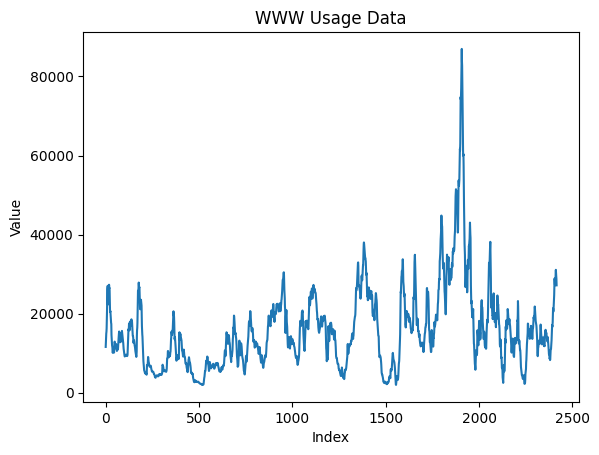

In [6]:
df = pd.read_csv('./data/all_batca.csv')
print(f"Total samples: {len(df)}")
print(df.head())
df["CLOSE"].plot(kind='line', title='WWW Usage Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

values = df["CLOSE"]

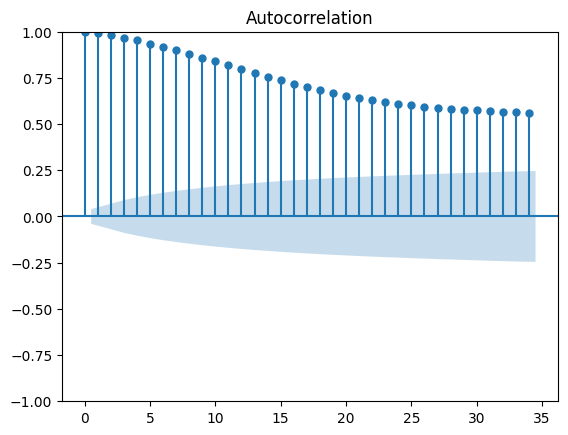

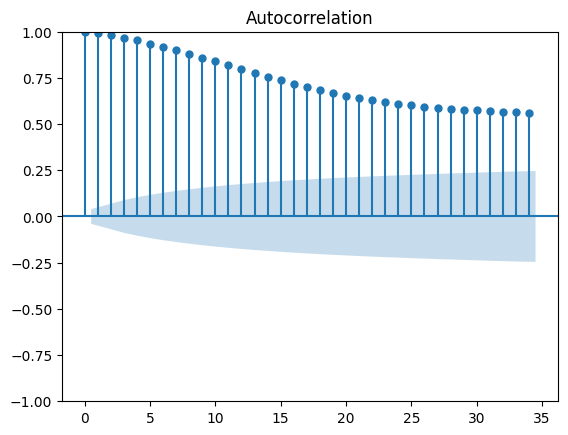

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(values)


In [8]:
# augmented dickey fuller

from statsmodels.tsa.stattools import adfuller

result = adfuller(values.dropna())
print('p-value: ', result[1])

result = adfuller(values.diff().dropna())
print('p-value: ', result[1])

result = adfuller(values.diff().diff().dropna())
print('p-value: ', result[1])


p-value:  5.09428428874935e-06
p-value:  5.041717824859882e-24
p-value:  3.460543035697896e-28


/Users/mariusbolstad/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mariusbolstad/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mariusbolstad/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                 2000
Model:                 ARIMA(8, 1, 8)   Log Likelihood              -16150.658
Date:                Wed, 25 Oct 2023   AIC                          32335.317
Time:                        18:11:48   BIC                          32430.524
Sample:                             0   HQIC                         32370.276
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2805      0.170      1.648      0.099      -0.053       0.614
ar.L2          0.1504      0.177      0.850      0.395      -0.196       0.497
ar.L3          0.7005      0.161      4.350      0

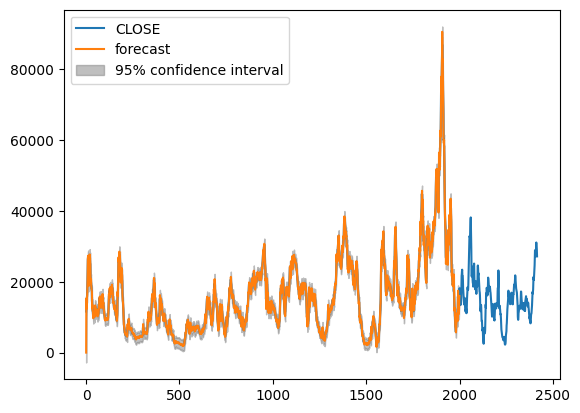

In [20]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Fit the ARIMA model
arima_model = ARIMA(values[:2000], order=(8,1,8))
model = arima_model.fit()

print(df.index[0])
print(model.summary())


fix, ax = plt.subplots()
ax = values.plot(ax=ax)
plot_predict(model,  ax=ax)
plt.show()


2       12288.552903
3       15001.103790
4       15454.980203
5       15643.218768
6       16876.181939
            ...     
1995    13678.341508
1996    10928.320738
1997    12222.493452
1998    15177.793093
1999    16000.948313
Length: 1998, dtype: float64
2000    17579.976557
2001    17984.642408
2002    18196.290484
2003    18306.986526
2004    18364.882699
2005    18395.163519
2006    18411.000974
2007    18419.284270
2008    18423.616594
2009    18425.882483
2010    18427.067587
2011    18427.687420
2012    18428.011604
2013    18428.181159
2014    18428.269839
2015    18428.316221
2016    18428.340479
2017    18428.353167
2018    18428.359803
2019    18428.363273
Name: predicted_mean, dtype: float64
2       12288.552903
3       15001.103790
4       15454.980203
5       15643.218768
6       16876.181939
            ...     
2015    18428.316221
2016    18428.340479
2017    18428.353167
2018    18428.359803
2019    18428.363273
Length: 2018, dtype: float64


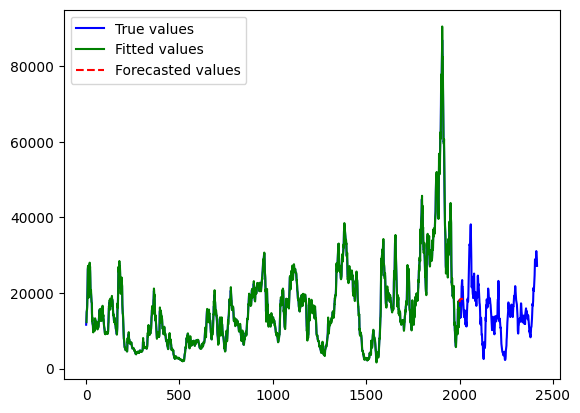

In [19]:
import pandas as pd
import numpy as np

# Create a series of predicted values
y_fitted = model.fittedvalues[2:]
y_pred = model.forecast(20)
print(y_fitted)
print(y_pred)
y = pd.concat([y_fitted, y_pred])
print(y)

# Get the actual values from the dataframe for comparison
y_true_full = values
y_true = values[2000:]

fig, ax = plt.subplots()

# Plot the true values
ax.plot(y_true_full.index, y_true_full, label='True values', color='blue')

# Plot the fitted values (up to 80)
ax.plot(y_fitted.index, y_fitted, label='Fitted values', color='green')

# Plot the forecasted values (from 80 onwards)
ax.plot(y_pred.index, y_pred, label='Forecasted values', color='red', linestyle='--')

# Set the legend
ax.legend()

plt.show()




In [74]:
import pprint

# Compute error metrics
mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))  # Mean absolute percentage error
mae = np.mean(np.abs(y_pred - y_true))                    # Mean absolute error
mpe = np.mean((y_pred - y_true) / y_true)                 # Mean percentage error
rmse = np.sqrt(np.mean((y_pred - y_true)**2))             # Root Mean Squared Error
corr = np.corrcoef(y_pred, y_true)[0, 1]                  # Correlation Coefficient

# MinMax Error
mins = np.minimum(y_pred, y_true)
maxs = np.maximum(y_pred, y_true)
minmax = 1 - np.mean(mins / maxs)

# Print results using pretty print
metrics = {
    'mape': mape,
    'mae': mae,
    'mpe': mpe,
    'rmse': rmse,
    'corr': corr,
    'minmax': minmax
}

pprint.pprint(metrics)







{'corr': 0.9328652877618426,
 'mae': 54.68535812494773,
 'mape': 0.27448845286833146,
 'minmax': 0.27448845286833146,
 'mpe': -0.27448845286833146,
 'rmse': 61.38905719838215}
